# Copy-Paste Augmentation for Fish Detection

This notebook demonstrates the complete pipeline for copy-paste augmentation as described in the project README.

## 1. Setup Environment

In [ ]:
%pip install -r requirements.txt
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random

# Verify GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1
CUDA available: True


## 2. Extract Fish Masks

In [2]:
!python get_masks.py \
  --images sample_data/train/images \
  --labels sample_data/train/labels \
  --output sample_data/masks/extracted_masks \
  --model sam2.1_b.pt

Processing 25 images...
Extracting masks: 100%|██████████████| 25/25 [00:05<00:00,  4.23it/s, Masks=132]

Processing complete!
Total masks extracted: 132
Masks saved to: sample_data/masks/extracted_masks


## 3. Filter Masks

### 3.1 Automatic Filtering

In [3]:
!python auto_filtering.py sample_data/masks/extracted_masks sample_data/masks/filtered_masks --min_size_kb 10 --max_components 3

print("\nFiltering results:")
print(f"Passed masks: {len(os.listdir('sample_data/masks/filtered_masks/passed'))}")
print(f"Failed masks: {len(os.listdir('sample_data/masks/filtered_masks/failed'))}")

Filtering masks: 100%|██████████████████████| 132/132 [00:00<00:00, 2743.24it/s]
Filtering complete. Results saved in sample_data/masks/filtered_masks
Passed masks: sample_data/masks/filtered_masks/passed
Failed masks: sample_data/masks/filtered_masks/failed

Filtering results:
Passed masks: 52
Failed masks: 80


### 2.1 Manual Filtering (Optional)

In [4]:
# This cell is for documentation only - manual filtering requires interactive session
print("""
To run manual filtering, execute in terminal:
python manual_filtering.py --input sample_data/masks/filtered_masks/passed \
                         --failed sample_data/masks/failed \
                         --progress progress.txt

Keyboard controls:
y = keep, n = reject, u = undo, q = quit
""")


To run manual filtering, execute in terminal:
python manual_filtering.py --input sample_data/masks/filtered_masks/passed                          --failed sample_data/masks/failed                          --progress progress.txt

Keyboard controls:
y = keep, n = reject, u = undo, q = quit



## 4. Augment Masks

In [5]:
!python augment_masks.py sample_data/masks/filtered_masks/passed sample_data/masks/passed_augmented_masks \
  --num_augmentations 2 \
  --rotation_range=-30,40 \
  --scale_range 0.7,1.3

Augmented masks saved to: sample_data/masks/passed_augmented_masks


## 5. Copy-Paste Augmentation

In [6]:
!python copy_paste.py \
  --images sample_data/train/images \
  --labels sample_data/train/labels \
  --masks sample_data/masks/passed_augmented_masks \
  --output sample_data/augmented_dataset \
  --prob 0.5 \
  --min-objects 8 \
  --max-objects 12 \
  --env-paste


Total augmented images: 13
Complete dataset saved to: sample_data/augmented_dataset
Done


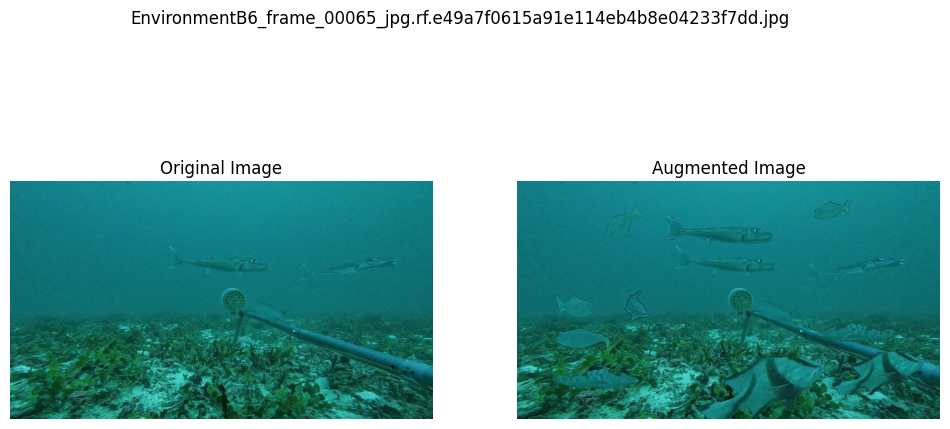

In [7]:
def visualize_augmented_pair(original_dir, augmented_dir, suffix="_aug.jpg"):
    # Get all augmented images
    augmented_images = [f for f in os.listdir(augmented_dir) if f.endswith(suffix)]
    
    if not augmented_images:
        print("No augmented images found.")
        return

    # Pick a random augmented image
    aug_image_name = random.choice(augmented_images)

    # Derive the original image name by removing the suffix
    original_image_name = aug_image_name.replace(suffix, ".jpg")

    # Construct full paths
    original_path = os.path.join(original_dir, original_image_name)
    augmented_path = os.path.join(augmented_dir, aug_image_name)

    # Load images
    original = cv2.imread(original_path)
    augmented = cv2.imread(augmented_path)

    if original is None:
        print(f"Original image not found: {original_path}")
        return
    if augmented is None:
        print(f"Augmented image not found or could not be read: {augmented_path}")
        return

    # Show side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(cv2.cvtColor(augmented, cv2.COLOR_BGR2RGB))
    ax2.set_title('Augmented Image')
    ax2.axis('off')

    plt.suptitle(original_image_name)
    plt.show()

# Example usage
original_dir = "sample_data/train/images"
augmented_dir = "sample_data/augmented_dataset/images"
visualize_augmented_pair(original_dir, augmented_dir)


## 5. Training with Augmented Data

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained model
model = YOLO("yolo11n.pt")

# Train the model on the augmented dataset example dataset for 100 epochs
results = model.train(data="sample_data/data.yaml", epochs=10, imgsz=640)